# Notebook imports

In [87]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [107]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'
TRAIN_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMB_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMB_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

# Reading file

In [3]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator function

In [6]:
def generate_squares(N):
    for i in range(N):
        yield i ** 2

In [7]:
for i in generate_squares(4):
    print(i, end = '->')

0->1->4->9->

# Email body extraction

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding = 'latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe: ', data.shape)
data.head()

Shape of entire dataframe:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [15]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning : Checking for Missing Values

In [16]:
data.MESSAGE.isnull().values.any()

False

In [17]:
(data.MESSAGE.str.len() == 0).any()

True

In [18]:
(data.MESSAGE.str.len() == 0).sum()

3

## Locate Empty Emails

In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove system file entries from data frame

In [20]:
# data = data.drop(['cmds'])
# data.drop(['cmds'], inplace = True)      Both are same

data.drop(['cmds'], inplace = True)
(data.MESSAGE.str.len() == 0).any()

False

In [21]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [22]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [23]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int32

In [24]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [25]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save to file using Pandas

In [26]:
data.to_json(DATA_JSON_FILE)

# Number of Spam messages visualised (Pie charts)

In [27]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [28]:
amounts_of_spam = data.CATEGORY.value_counts()[1]
amounts_of_ham = data.CATEGORY.value_counts()[0]

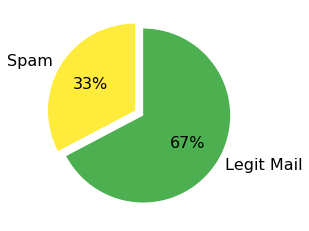

In [29]:
category_names = ['Spam', 'Legit Mail']
sizes = [amounts_of_spam, amounts_of_ham]

plt.pie(sizes, labels = category_names, textprops = {'fontsize': 16}, startangle = 90, autopct= '%1.0f%%', 
       colors = ['#FFEB3B', '#4CAF50'], explode = [0.1, 0.01])
plt.show()

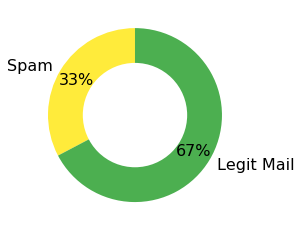

In [30]:
category_names = ['Spam', 'Legit Mail']
sizes = [amounts_of_spam, amounts_of_ham]

plt.pie(sizes, labels = category_names, textprops = {'fontsize': 16}, startangle = 90, autopct= '%1.0f%%', 
       colors = ['#FFEB3B', '#4CAF50'], pctdistance=0.79)

# draw circle
center_circle = plt.Circle((0, 0), radius = 0.6, fc = 'white')
plt.gca().add_artist(center_circle)

plt.show()

# NLP

## Text Preprocessing

In [31]:
msg = 'sjanksAS AS'
msg.lower()

'sjanksas as'

## Download the NLTK Resources (Tokenizer & stopwords)

In [32]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenizing

In [35]:
msg = 'All assholes suck my Cock and die.'
word_tokenize(msg.lower())

['all', 'assholes', 'suck', 'my', 'cock', 'and', 'die', '.']

## Removing stopwords

In [36]:
stop_words = set(stopwords.words('english'))

In [37]:
msg = 'All assholes suck my Cock and die. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

In [38]:
filtered_words

['assholes', 'suck', 'cock', 'die', '.', '.']

## Word stems and stemming

In [39]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing Punctuation

In [40]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Email

In [41]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
 </body>
</html>
<tr>
 <td colspan="3D3">
  <hr color="3Dblack" noshade="" size="3D1"/>
 </td>
</tr>
<!-- End Calypso -->
<!-- Inserted by Calypso=

 -->
<font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
 <br/>
</font>
&lt;=

/TR&gt;
<!-- End Calypso -->
<font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
 <center>
  Save up to 70% on Life Insurance.
 </ce

In [42]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Functions for email Processing

In [43]:
def clean_message(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [44]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [45]:
def clean_msg_no_html(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    message = soup.get_text()
    
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [46]:
clean_msg_no_html(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenisation to all messages

## Slicing DataFrames & Series and Creating subsets

In [47]:
data.iat[1, 1]

1

In [48]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_msg_no_html)

In [49]:
flat_list = []

for sub_list in nested_list:
    for word in sub_list:
        flat_list.append(word)
        
len(flat_list)

192

In [50]:
flat_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [51]:
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\acer\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [52]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using logic to slice DataFrames

In [53]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [54]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
1894,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
1895,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [55]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [56]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

## Subsetting a Series with an Index

In [57]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [58]:
nested_list_ham.shape

(3900,)

In [59]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [60]:
flat_list_spam = []

for sub_list in nested_list_spam:
    for word in sub_list:
        flat_list_spam.append(word)
        
flat_list_ham = []

for sub_list in nested_list_ham:
    for word in sub_list:
        flat_list_ham.append(word)
        

In [61]:
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]

20755

In [62]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [63]:
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]

13284

In [64]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

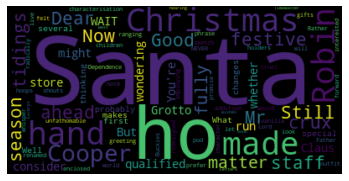

In [65]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [66]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [67]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [68]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

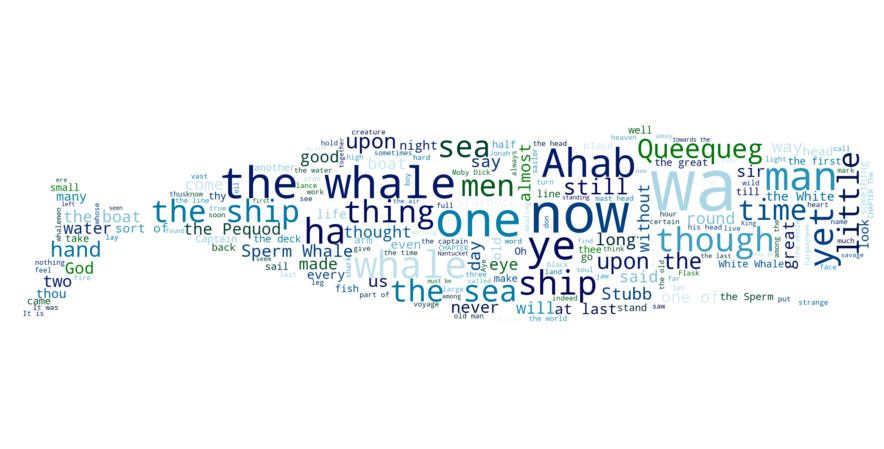

In [69]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255))
image_mask.paste(icon, box = icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask = rgb_array, background_color = 'white', max_words=200, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize = [16, 8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [70]:
example_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
novel_as_string

"[ The Tragedie of Hamlet by William Shakespeare 1599 ] Actus Primus . Scoena Prima . Enter Barnardo and Francisco two Centinels . Barnardo . Who ' s there ? Fran . Nay answer me : Stand & vnfold your selfe Bar . Long liue the King Fran . Barnardo ? Bar . He Fran . You come most carefully vpon your houre Bar . ' Tis now strook twelue , get thee to bed Francisco Fran . For this releefe much thankes : ' Tis bitter cold , And I am sicke at heart Barn . Haue you had quiet Guard ? Fran . Not a Mouse stirring Barn . Well , goodnight . If you do meet Horatio and Marcellus , the Riuals of my Watch , bid them make hast . Enter Horatio and Marcellus . Fran . I thinke I heare them . Stand : who ' s there ? Hor . Friends to this ground Mar . And Leige - men to the Dane Fran . Giue you good night Mar . O farwel honest Soldier , who hath relieu ' d you ? Fra . Barnardo ha ' s my place : giue you goodnight . Exit Fran . Mar . Holla Barnardo Bar . Say , what is Horatio there ? Hor . A peece of him Bar

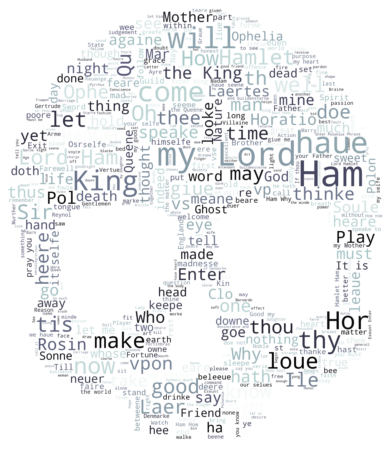

In [71]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255))
image_mask.paste(icon, box = icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask = rgb_array, background_color = 'white', max_words=500, colormap='bone')
word_cloud.generate(novel_as_string)

plt.figure(figsize = [16, 8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Word cloud of Ham and Spam words

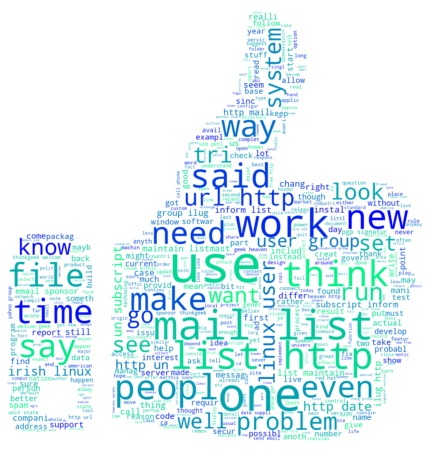

In [72]:
icon = Image.open(THUMB_UP_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255))
image_mask.paste(icon, box = icon)

rgb_array = np.array(image_mask)

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask = rgb_array, background_color = 'white', max_words=500, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize = [16, 8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

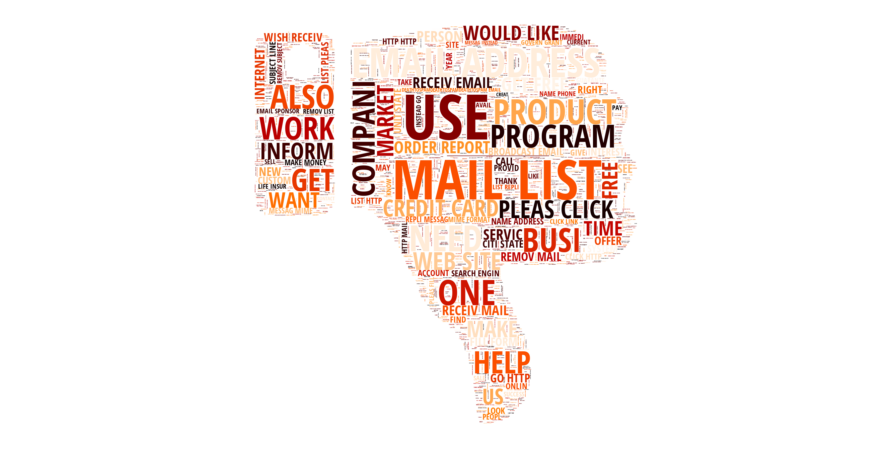

In [73]:
icon = Image.open(THUMB_DOWN_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color = (255, 255, 255))
image_mask.paste(icon, box = icon)

rgb_array = np.array(image_mask)

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask = rgb_array, background_color = 'white', max_words=2000, colormap='gist_heat', font_path = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf')
word_cloud.generate(spam_str.upper())

plt.figure(figsize = [16, 8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary and Dictionary

In [74]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
stemmed_flat_list = [item for i in stemmed_nested_list for item in i]

unique_words = pd.Series(stemmed_flat_list).value_counts()
print('No. of unique words: ', unique_words.shape)

C:\Users\acer\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


No. of unique words:  (27305,)


In [75]:
unique_words.head()

http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [76]:
frequent_words = unique_words[:VOCAB_SIZE]
print('Top 10: \n', frequent_words[:10])

Top 10: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


# Vocabulary DataFrame witg word_ID

In [77]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save vocab as csv file

In [78]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header = vocab.VOCAB_WORD.name)

## Exercise - Checking if word is a part of the vocabulary

In [79]:
'learn' in set(vocab.VOCAB_WORD)

True

In [80]:
any(vocab.VOCAB_WORD == 'machin')

True

## Exercise - Find the email with the longest number of words

In [81]:
clean_email_lengths = []
for sub in stemmed_nested_list:
    clean_email_lengths.append(len(sub))
print(max(clean_email_lengths))

7671


In [82]:
print('Email position :', np.argmax(clean_email_lengths))

Email position : 5775


In [83]:
stemmed_nested_list[5775]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [84]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate feautures and a sparse matrix

## Creating a dataframe

In [85]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [86]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


# Splitting Data

In [88]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size = 0.3, random_state = 42)

In [89]:
X_train.shape[0]

4057

In [91]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [92]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a sparse matrix for train data

In [93]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [94]:
word_index.get_loc('thu')

395

In [97]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns a sparse matrix as dataframe
    df: DataFrame
    indexed_words: index of words ordered by word id
    labels: category as a series
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
            
    return pd.DataFrame(dict_list)

In [98]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [99]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,266
1,0,4844,1,1258
2,0,4844,1,507
3,0,4844,1,310
4,0,4844,1,254


In [100]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
430986,1,860,1,47
430987,1,860,1,1438
430988,1,860,1,26
430989,1,860,1,19
430990,1,860,1,126


## Combine occurances with the pandas groupby() Method

In [101]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [102]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [103]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258360,5795,2043,0,1
258361,5795,2059,0,2
258362,5795,2297,0,1
258363,5795,2370,0,1
258364,5795,2420,0,1


## Save train data as .txt file

In [105]:
np.savetxt(TRAIN_DATA_FILE, train_grouped, fmt = '%d')

In [106]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [108]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [109]:
sparse_test_df.shape

(203142, 4)

In [110]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')

In [111]:
test_grouped.shape

(117619, 4)

In [112]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [113]:
len(train_doc_ids)

4015

In [114]:
len(test_doc_ids)

1724

In [116]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [120]:
data.MESSAGE[1670]

'------=_NextPart_000_00E5_50D62D7A.E1807C03\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPEhUTUw+DQo8SEVBRD4NCiAgIA0KICAgPFRJVExFPk1hcnJpZWQgQnV0IExv\n\nbmVseTwvVElUTEU+DQo8L0hFQUQ+DQo8Qk9EWSBCR0NPTE9SPSIjRkZGRkZG\n\nIiBMSU5LPSIjRkYwMDAwIiBWTElOSz0iI0ZGMDAwMCIgQUxJTks9IiNGRjAw\n\nMDAiPg0KDQo8UCBBTElHTj0iY2VudGVyIj4gPElNRyBCT1JERVI9IjAiIFNS\n\nQz0iaHR0cDovL3d3dy5wYWdlNGxpZmUub3JnL3VzZXJzL3h4eGRhdGluZy9t\n\nYXJyaWVkYW5kbG9uZWx5L2ltYWdlcy9sb2dvLmpwZyIgV0lEVEg9IjUwMCIg\n\nSEVJR0hUPSIxOTEiPiZuYnNwOyAmbmJzcDsgPC9QPg0KPENFTlRFUj4NCiAg\n\nPFRBQkxFIENFTExTUEFDSU5HPTUgQ0VMTFBBRERJTkc9NSBCR0NPTE9SPSIj\n\nNjY2Njk5IiA+DQogICAgPFRSPg0KPFREPjxJTUcgU1JDPSJodHRwOi8vd3d3\n\nLnBhZ2U0bGlmZS5vcmcvdXNlcnMveHh4ZGF0aW5nL21hcnJpZWRhbmRsb25l\n\nbHkvcDcwNi5qcGciIEJPUkRFUj0wIEhFSUdIVD0xODAgV0lEVEg9MTIwPjwv\n\nVEQ+DQoNCjxURD48SU1HIFNSQz0iaHR0cDovL3d3dy5wYWdlNGxpZmUub3Jn\n\nL3VzZXJzL3h4eGRhdGluZy9tYXJyaWVkYW5kbG9uZWx5L3A3MDQuanBnIiBC\n\nT1JERVI9MCBIRUlHSFQ9MTgwIF